In [202]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [203]:
df = pd.read_csv("data.csv")
df.sample(5, random_state=1)

,location,voivodship,area,ownership,rooms,floor,outdoor_space,rent,parking,heating,advertiser,construction_year,building,elevator,price
38857,Niepołomice,małopolskie,60.00,pełna własność,3.0,0.0,"ogródek, taras",0.0,1.0,gazowe,biuro nieruchomości,2018.0,blok,0.0,750000.0
18978,Toruń,kujawsko-pomorskie,64.00,pełna własność,3.0,1.0,balkon,690.0,0.0,NaN,biuro nieruchomości,2009.0,NaN,0.0,619000.0
41215,Szczecin,zachodniopomorskie,77.59,pełna własność,3.0,4.0,none,647.0,0.0,miejskie,biuro nieruchomości,1988.0,blok,0.0,475000.0
9133,Warszawa,mazowieckie,19.00,pełna własność,1.0,3.0,none,338.0,0.0,miejskie,biuro nieruchomości,1935.0,kamienica,0.0,480000.0
896,Warszawa,mazowieckie,58.90,pełna własność,2.0,0.0,ogródek,874.0,1.0,kotłownia,biuro nieruchomości,2001.0,blok,1.0,939000.0


In [204]:
df.shape

(56934, 15)

In [205]:
df.describe()

,area,rooms,floor,rent,parking,construction_year,elevator,price
count,5.693400e+04,56934.000000,56104.000000,5.693400e+04,56934.000000,4.085800e+04,56934.000000,5.693400e+04
mean,2.427009e+02,2.603119,2.398011,4.530450e+02,0.378789,3.471760e+03,0.317051,6.635477e+05
std,2.246327e+04,1.010006,2.211031,6.346304e+03,0.485090,1.733440e+05,0.465332,6.810282e+05
min,5.040000e+00,1.000000,-1.000000,0.000000e+00,0.000000,1.000000e+00,0.000000,2.400000e+03
25%,4.300000e+01,2.000000,1.000000,0.000000e+00,0.000000,1.970000e+03,0.000000,3.490000e+05
50%,5.310000e+01,3.000000,2.000000,4.000000e+02,0.000000,1.991000e+03,0.000000,5.300000e+05
75%,6.732000e+01,3.000000,3.000000,6.500000e+02,1.000000,2.016000e+03,1.000000,7.700000e+05
max,3.777480e+06,11.000000,25.000000,1.300000e+06,1.000000,2.023202e+07,1.000000,4.300000e+07


In [206]:
pd.DataFrame({
            'Data Type': df.dtypes,
            'Missing Values count': df.isna().sum(),
            'Missing Values %': round((df.isna().sum() / len(df) * 100),2),
        }).sort_values(by='Missing Values %', ascending=False)

,Data Type,Missing Values count,Missing Values %
construction_year,float64,16076,28.24
ownership,object,13271,23.31
heating,object,10376,18.22
building,object,8097,14.22
floor,float64,830,1.46
location,object,25,0.04
voivodship,object,22,0.04
area,float64,0,0.00
rooms,float64,0,0.00
outdoor_space,object,0,0.00


In [207]:
num = ["construction_year", "floor", "area", "rooms", "rent", "parking", "elevator", "price"]
categ = [col for col in df.columns if col not in num]

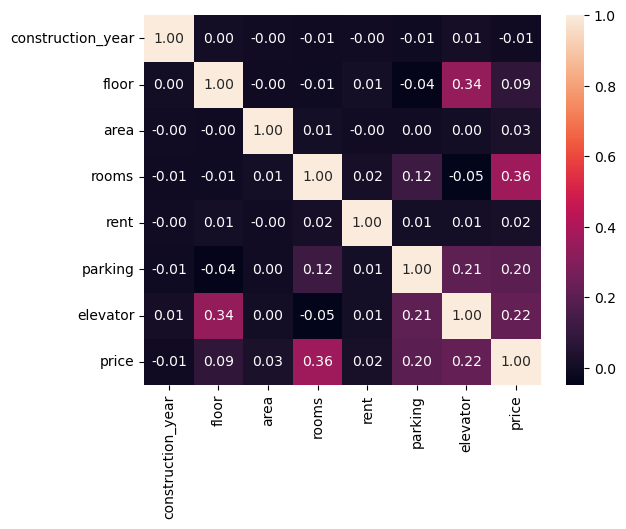

In [208]:
sns.heatmap(df[num].corr(), annot=True, fmt = '.2f')
plt.show()

In [209]:
df[categ] = df[categ].fillna('missing')
df[["construction_year"]] = df[["construction_year"]].fillna(np.median(df.construction_year.dropna()))
df[["floor"]] = df[["floor"]].fillna(np.median(df.floor.dropna()))

In [210]:
df.isna().sum().sum()

0

In [211]:
def remove_outliers(df):
    df_cleaned = df.copy()
    for col in num:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] > lower_bound) & (df_cleaned[col] < upper_bound)]
    return df_cleaned

print(df.shape)
df = remove_outliers(df)
print(df.shape)


(56934, 15)
(44204, 15)


In [212]:
df.describe()

,area,rooms,floor,rent,parking,construction_year,elevator,price
count,44204.000000,44204.000000,44204.000000,44204.000000,44204.000000,44204.000000,44204.000000,4.420400e+04
mean,52.788394,2.434440,1.915551,374.588885,0.360035,1991.309090,0.268935,5.265355e+05
std,15.978860,0.789082,1.428710,327.650434,0.480016,22.027557,0.443411,2.503542e+05
min,7.870000,1.000000,-1.000000,0.000000,0.000000,1928.000000,0.000000,2.400000e+03
25%,41.537500,2.000000,1.000000,0.000000,0.000000,1980.000000,0.000000,3.290000e+05
50%,51.000000,2.000000,2.000000,400.000000,0.000000,1991.000000,0.000000,4.873500e+05
75%,62.570000,3.000000,3.000000,610.000000,1.000000,2010.000000,1.000000,6.890000e+05
max,102.930000,4.000000,5.000000,1550.000000,1.000000,2026.000000,1.000000,1.288710e+06


In [213]:
df = df[df['construction_year'] < 2024]
df = df[df['price'] < 1000000]
df.shape

(40950, 15)

In [214]:
for col in categ:
    print(df[col].unique(), "\n")

['Rybnik' 'Rzeszów' 'Lublin' ... 'Cieszanów' 'Mszana Dolna' 'Turobin'] 

['śląskie' 'podkarpackie' 'lubelskie' 'pomorskie' 'zachodniopomorskie'
 'mazowieckie' 'dolnośląskie' 'małopolskie' 'podlaskie' 'łódzkie'
 'lubuskie' 'kujawsko-pomorskie' 'wielkopolskie' 'warmińsko-mazurskie'
 'opolskie' 'świętokrzyskie' 'missing'] 

['spółdzielcze wł. prawo do lokalu' 'pełna własność' 'udział'
 'użytkowanie wieczyste / dzierżawa' 'missing'] 

['balkon' 'none' 'ogródek' 'taras' 'ogródek, taras' 'balkon, ogródek'
 'balkon, taras' 'balkon, ogródek, taras' 'taras, ogródek' 'taras, balkon'
 'taras, balkon, ogródek' 'balkon, taras, ogródek'] 

['miejskie' 'inne' 'gazowe' 'elektryczne' 'kotłownia' 'piece kaflowe'
 'missing'] 

['biuro nieruchomości' 'prywatny'] 

['blok' 'apartamentowiec' 'kamienica' 'dom wolnostojący' 'szeregowiec'
 'loft' 'plomba' 'missing'] 



In [215]:
def outdoor_space_formating(space):
    if space == 'none':
        return 'none'
    return ', '.join(sorted(space.split(', ')))

df['outdoor_space'] = df['outdoor_space'].apply(outdoor_space_formating)

In [216]:
print(df.duplicated().sum())

0


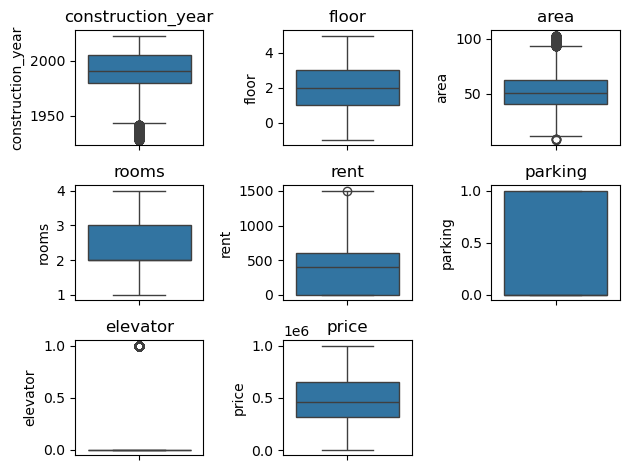

In [217]:
for i, col in enumerate(num, 1):
    plt.subplot(3, 3, i) 
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [218]:
X = df.drop(columns=['price'])
y = df['price']
num.remove("price")

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

In [219]:
print(X_train.shape, X_val.shape, X_test.shape)

(24570, 14) (8190, 14) (8190, 14)


In [220]:
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoder.fit(X_train[categ])

X_train_encoded = pd.DataFrame(encoder.transform(X_train[categ]), columns=encoder.get_feature_names_out(categ))
X_val_encoded = pd.DataFrame(encoder.transform(X_val[categ]), columns=encoder.get_feature_names_out(categ))
X_test_encoded = pd.DataFrame(encoder.transform(X_test[categ]), columns=encoder.get_feature_names_out(categ))

X_train = pd.concat([X_train.drop(categ, axis=1).reset_index(drop=True), X_train_encoded], axis=1)
X_val = pd.concat([X_val.drop(categ, axis=1).reset_index(drop=True), X_val_encoded], axis=1)
X_test = pd.concat([X_test.drop(categ, axis=1).reset_index(drop=True), X_test_encoded], axis=1)


/Users/andrik/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/andrik/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [221]:
scaler = StandardScaler()

X_train[num] = scaler.fit_transform(X_train[num])
X_val[num] = scaler.transform(X_val[num])
X_test[num] = scaler.transform(X_test[num])

In [222]:
X_train = X_train.astype({col: 'float64' for col in X_train.select_dtypes('bool').columns})
X_val = X_val.astype({col: 'float64' for col in X_val.select_dtypes('bool').columns})
X_test = X_test.astype({col: 'float64' for col in X_test.select_dtypes('bool').columns})

In [223]:
def model_results(y_pred, y_pred_train):    
    r2_val = round(r2_score(y_val, y_pred), 4)
    rmse_val = round(np.sqrt(mean_squared_error(y_val, y_pred)))
    mae_val = round(mean_absolute_error(y_val, y_pred))
    
    r2_train = round(r2_score(y_train, y_pred_train), 4)
    rmse_train = round(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    mae_train = round(mean_absolute_error(y_train, y_pred_train))
    
    if r2_val < 0:
        r2_val = 0
        rmse_val = 900000
        mae_val = 10000000

    scores.loc[len(scores.index)] = [r2_val, rmse_val, mae_val, r2_train, rmse_train, mae_train]
    return

scores = pd.DataFrame({
    "R^2_val": [],
    "RMSE_val": [],
    "MAE_val": [],
    "R^2_train": [],
    "RMSE_train": [],
    "MAE_train": []
})


In [224]:
model_lr = LinearRegression()

model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_val)
y_pred_train = model_lr.predict(X_train)

model_results(y_pred, y_pred_train)

In [225]:
model_ridge = Ridge() 

model_ridge.fit(X_train, y_train)
y_pred = model_ridge.predict(X_val)
y_pred_train = model_ridge.predict(X_train)

model_results(y_pred, y_pred_train)

In [226]:
model_KNN = KNeighborsRegressor(n_neighbors=5)  

model_KNN.fit(X_train, y_train)
y_pred = model_KNN.predict(X_val)
y_pred_train = model_KNN.predict(X_train)

model_results(y_pred, y_pred_train)

In [227]:
model_tree = DecisionTreeRegressor(max_depth = 7)

model_tree.fit(X_train, y_train)
y_pred = model_tree.predict(X_val)
y_pred_train = model_tree.predict(X_train)

model_results(y_pred, y_pred_train)

In [228]:
model_rf = RandomForestRegressor()

model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_val)
y_pred_train = model_rf.predict(X_train)

model_results(y_pred, y_pred_train)

In [229]:
model_xgb = XGBRegressor()

model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_val)
y_pred_train = model_xgb.predict(X_train)

model_results(y_pred, y_pred_train)

In [230]:
from keras.layers import InputLayer, Dense
from keras.models import Sequential
from keras.optimizers import Adam


model_nn = Sequential([
    InputLayer((X_train.shape[1],)),
    Dense(2048, "relu"),
    Dense(2048, "relu"),
    Dense(2048, "relu"),
    Dense(1024, "relu"),
    Dense(1)
])

model_nn.compile(optimizer=Adam(learning_rate = 0.001), loss='mean_squared_error')
model_nn.fit(X_train, y_train, epochs=5, batch_size=32) 

y_pred = model_nn.predict(X_val)
y_pred_train = model_nn.predict(X_train)

model_results(y_pred, y_pred_train)

Epoch 1/5


2024-10-23 18:20:14.219681: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


768/768 ━━━━━━━━━━━━━━━━━━━━ 38s 47ms/step - loss: 53699416064.0000
Epoch 2/5
768/768 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 8753678336.0000
Epoch 3/5
768/768 ━━━━━━━━━━━━━━━━━━━━ 37s 48ms/step - loss: 7739335680.0000
Epoch 4/5
768/768 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - loss: 7540748288.0000
Epoch 5/5
768/768 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - loss: 7511514624.0000
 42/256 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

2024-10-23 18:23:30.923722: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [231]:
scores.index = ["Linear", "Ridge", "KNN", "DecisionTree", "RandomForest", "XGBoost", "NN"]
scores.sort_values(by='RMSE_val', ascending=True)

,R^2_val,RMSE_val,MAE_val,R^2_train,RMSE_train,MAE_train
XGBoost,0.8153,92851.0,69296.0,0.8591,80951.0,60496.0
NN,0.8070,94898.0,69886.0,0.8440,85182.0,61547.0
RandomForest,0.7981,97061.0,70379.0,0.9710,36744.0,26184.0
Ridge,0.7969,97349.0,73347.0,0.8099,94038.0,69862.0
KNN,0.6673,124613.0,93116.0,0.7791,101368.0,75025.0
DecisionTree,0.6250,132298.0,101179.0,0.6284,131466.0,100125.0
Linear,0.0000,900000.0,10000000.0,0.8123,93430.0,68995.0


In [233]:
model_xgb.save_model('model.json')